In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from collections import deque

from sklearn.metrics import root_mean_squared_error as RMSE

import sys
import os

root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from utils.data_loaders import cv_splits_loader
from utils.data_loaders import test_dataset_loader

In [31]:
train_df, val_df = cv_splits_loader(split = 1)

In [33]:
train_df.head()

,N2O,NH4,NO3,N2O_lag1,N2O_lag2,N2O_lag3,N2O_lag4,N2O_lag5,N2O_lag6,N2O_lag7,...,NO3_lag13,NO3_lag14,NO3_lag15,NO3_lag16,NO3_lag17,NO3_lag18,NO3_lag19,NO3_lag20,N2O_lead1,N2O_lead2
time,,,,,,,,,,,,,,,,,,,,,
2022-06-12 02:20:00,0.459780,0.802299,1.563254,0.383073,0.268895,0.217766,0.163310,0.102662,0.037095,0.016088,...,1.418028,1.182717,0.912930,0.482552,0.123406,0.005908,0.018822,0.061391,0.532986,0.535417
2022-06-12 02:30:00,0.532986,1.036766,1.079640,0.459780,0.383073,0.268895,0.217766,0.163310,0.102662,0.037095,...,1.048384,1.418028,1.182717,0.912930,0.482552,0.123406,0.005908,0.018822,0.535417,0.449248
2022-06-12 02:40:00,0.535417,0.946469,0.694841,0.532986,0.459780,0.383073,0.268895,0.217766,0.163310,0.102662,...,0.496807,1.048384,1.418028,1.182717,0.912930,0.482552,0.123406,0.005908,0.449248,0.205990
2022-06-12 02:50:00,0.449248,1.065319,0.313555,0.535417,0.532986,0.459780,0.383073,0.268895,0.217766,0.163310,...,0.081347,0.496807,1.048384,1.418028,1.182717,0.912930,0.482552,0.123406,0.205990,0.006684
2022-06-12 03:00:00,0.205990,1.901509,0.048804,0.449248,0.535417,0.532986,0.459780,0.383073,0.268895,0.217766,...,0.005481,0.081347,0.496807,1.048384,1.418028,1.182717,0.912930,0.482552,0.006684,0.005411


# Modelling Setup

The goal is to take 22 hours of measurement of the tank variables, and predict the next 30 minutes of N2O.



## Naive Baseline Model

The predicted values of N2O are all equal to the last observed value.

In [319]:
class NaivePersistence():
    """
    A simple baseline forecasting model that predicts future N2O values as the most recently observed (lagged) value.
    """

    required_features = ['N2O_lag1']
    target_features = ['N2O', 'N2O_lead1', 'N2O_lead2']
    
    def __init__(self):
        pass

    def _dp_transform(self, X):
        """
        Takes a datapoint of the standard form, and returns the datapoint with only the necessary columns. For this model,
        the only necessary column for predicting is 'N2O_lag1'.

        Args:
            X (DataFrame): DataFrame of datapoints in the standard form.

        Returns:
            X (DataFrame): DataFrame containing only the 'N2O_lag1' column.
        """

        X = X[self.required_features].copy()
        
        return X

    def predict(self, X):
        """
        Takes a standard datapoint, and predicts the next 3 values of N2O as the last observed values of N2O.

        Args:
            X (DataFrame): DataFrame of datapoints in the standard form.

        Returns:
            y (DataFrame): DataFrame with the predicted values of 'N2O', 'N2O_lead1', and 'N2O_lead2'.
        """

        X = self._dp_transform(X)

        y = pd.DataFrame(index = X.index)

        y['N2O'] = X['N2O_lag1']
        y['N2O_lead1'] = X['N2O_lag1']
        y['N2O_lead2'] = X['N2O_lag1']
        
        return y[self.target_features]

class NaiveRollingMean():
    """
    A simple baseline forecasting model that predicts future N2O values
    as the rolling mean of the most recently observed lagged values.
    """

    required_features = ['N2O_lag1']
    target_features = ['N2O', 'N2O_lead1', 'N2O_lead2']
    
    def __init__(self, window_size = 3):
        
        assert 1 < window_size < 21, "Window size must be greater than 1."
        self.window_size = window_size
        
        self.required_features = []
        
        for i in range(1, window_size + 1):
            self.required_features.append(f"N2O_lag{i}")

    def _dp_transform(self, X):
        """
        Takes a datapoint of the standard form, and returns the datapoint with only the necessary columns. For this model,
        the only necessary column for predicting is 'N2O_lag1'.

        Args:
            X (DataFrame): DataFrame of datapoints in the standard form.

        Returns:
            X (DataFrame): DataFrame containing only the 'N2O_lag1' column.
        """

        X = X[self.required_features].copy()
        
        return X

    def predict(self, X):
        """
        Takes a standard datapoint, and predicts the next 3 values of N2O as rolling means of the most recent lagged values.

        Args:
            X (DataFrame): DataFrame of datapoints in the standard form.

        Returns:
            y (DataFrame): DataFrame with the predicted values of 'N2O', 'N2O_lead1', and 'N2O_lead2'.
        """

        X = self._dp_transform(X)

        y = pd.DataFrame(index = X.index)

        cols_to_mean = list(self.required_features)

        y['N2O'] = X[cols_to_mean].mean(axis=1)
        cols_to_mean = ['N2O'] + cols_to_mean[:-1]
        X['N2O'] = y['N2O']
        X = X[cols_to_mean]
        
        y['N2O_lead1'] = X[cols_to_mean].mean(axis=1)
        cols_to_mean = ['N2O_lead1'] + cols_to_mean[:-1]
        X['N2O_lead1'] = y['N2O_lead1']
        X = X[cols_to_mean]
        
        y['N2O_lead2'] = X[cols_to_mean].mean(axis=1)
        
        return y[self.target_features]

def model_eval(model):

    errors = []

    for i in range(1, 8): # 8 data splits
        train_df, val_df = cv_splits_loader(split = i)

        train_pred = model.predict(train_df)
        error = RMSE(train_df[['N2O', 'N2O_lead1', 'N2O_lead2']], train_pred[['N2O', 'N2O_lead1', 'N2O_lead2']])/len(train_df)
        errors.append(error)

        val_pred = model.predict(val_df)
        error = RMSE(val_df[['N2O', 'N2O_lead1', 'N2O_lead2']], val_pred[['N2O', 'N2O_lead1', 'N2O_lead2']])/len(val_df)
        errors.append(error)
    
    return errors


In [321]:
def plot_pred(model, datapoint, output_path = None):

    current_time = datapoint.index[0]

    n_past = 20
    n_future = 2

    time_array = pd.date_range(end = current_time + pd.Timedelta(minutes=n_future*10), periods=n_past + 1 + n_future, freq='10min')

    truth_upto = datapoint[[f'N2O_lag{lag}' for lag in range(20, 0, -1)]].to_numpy()[0]
    truth_to_compare = datapoint[['N2O', 'N2O_lead1', 'N2O_lead2']].to_numpy()[0]
    pred = model.predict(datapoint).to_numpy()[0]

    plt.plot(time_array, np.concatenate((truth_upto, truth_to_compare)), linestyle=':', color = 'r', linewidth = 3, label = 'Truth')
    plt.plot(time_array, np.concatenate((truth_upto, pred)), color = 'maroon', linewidth = 2.7, label = 'Prediction')
    plt.plot(time_array[:20], truth_upto, color = 'r',linewidth = 3)
    plt.legend()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.gca().xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,10)))
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('N2O') # add units
    plt.title('N2O Prediction vs Truth')
    plt.legend()
    
    if output_path:
        pass


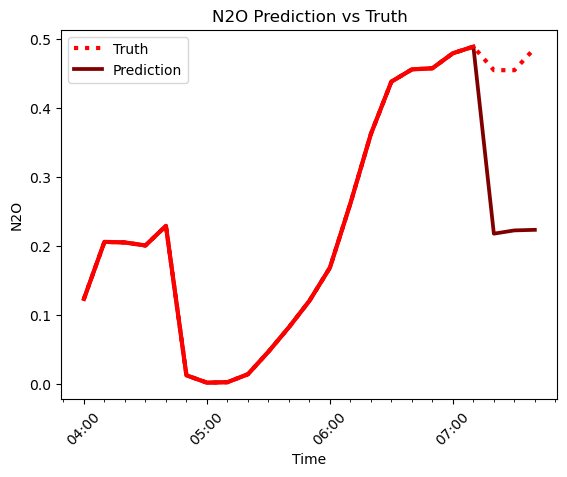

In [323]:
naive = NaiveRollingMean(20)
dp = train_df.iloc[[30]]

plot_pred(naive, dp)

In [83]:
naive = NaivePersistence()

In [85]:
errors_arr = model_eval(naive)

In [87]:
np.mean(errors_arr)*1e6

4.265968646636183

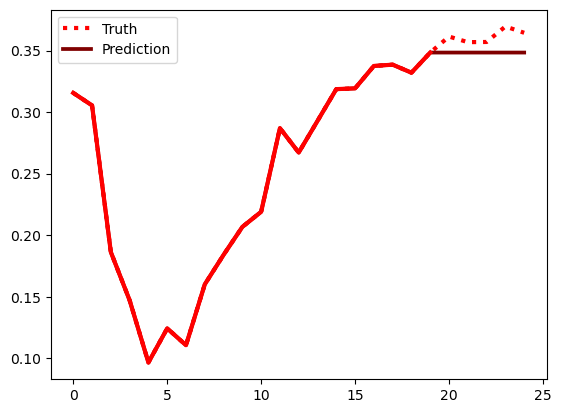

In [217]:
plot_test_TRUTH = val_df[600:600 + 25]['N2O'].to_numpy()
plot_test_baseline_pred = np.concatenate((plot_test_TRUTH[:-LEN_PRED_HORIZON], naive_persistence(plot_test_TRUTH[:-LEN_PRED_HORIZON])))


plt.plot(plot_test_TRUTH[:], linestyle=':', color = 'r', linewidth = 3, label = 'Truth')
plt.plot(plot_test_baseline_pred[:], color = 'maroon', linewidth = 2.7, label = 'Prediction')
plt.plot(plot_test_TRUTH[:-LEN_PRED_HORIZON], color = 'r',linewidth = 3)
plt.legend()

In [105]:
for i in range(2, 21):
    naive_mean = NaiveRollingMean(window_size = i)
    errors_arr = model_eval(naive_mean)
    print(f"w = {i}, error = {np.mean(errors_arr)*1e6}")

w = 2, error = 4.603892785459332
w = 3, error = 4.906204107507415
w = 4, error = 5.198550136431159
w = 5, error = 5.425649487856316
w = 6, error = 5.587058710235333
w = 7, error = 5.699767387158149
w = 8, error = 5.782704190800969
w = 9, error = 5.847276454800044
w = 10, error = 5.899963143311147
w = 11, error = 5.94649689288757
w = 12, error = 5.993107166462706
w = 13, error = 6.044540771408056
w = 14, error = 6.103699950714239
w = 15, error = 6.171897487689086
w = 16, error = 6.24911128177691
w = 17, error = 6.33325232469843
w = 18, error = 6.420402638519748
w = 19, error = 6.507320639232561
w = 20, error = 6.591877823267965


In [219]:
def naive_rolling_mean(series, window, horizon = LEN_PRED_HORIZON):
    """
    Evaluate a naive rolling mean baseline on a univariate time series for N2O.

    The rolling mean baseline predicts that the next value in a timestep is
    equal to the mean of the last observed values in the input window.

    This operation is recursively performed for the next `horizon` values.

    Parameters
    ----------
    series : array-like
        1D array or Pandas Series containing the time series values for N2O.
    window : int
        Number of previous timesteps to consider in the rolling mean.
    horizon : int
        Number of future timesteps to predict.

    Returns
    -------
    array
        1D array predicting the next `horizon` values.
    """

    dq = deque(series[-horizon:])

    cumsum = sum(list(dq)[-window:])

    for i in range(horizon):
        mean_last_n = cumsum/window
        dq.append(mean_last_n)
        removed = dq.popleft()
        cumsum -= removed
        cumsum += mean_last_n
    
    return np.array(list(dq)[-horizon:])


def tuning_rolling_mean(datapoints, w):

    errors = []

    for i, datapoint in enumerate(datapoints):
        errors.append(RMSE(naive_rolling_mean(datapoint[:-LEN_PRED_HORIZON], window=w, horizon=LEN_PRED_HORIZON), datapoint[-LEN_PRED_HORIZON:]))

    return np.mean(errors)
    

In [221]:
# Select 500 random datapoints
print("initiating batching")

N_DATA_TO_TEST = 500
N2O_vals = train_df['N2O'].to_numpy()
total_len = len(N2O_vals)
window_size = N_ROWS_IN_DAY

valid_indices = []
for start in range(total_len - window_size + 1):
    window = N2O_vals[start:start + window_size]
    if not np.isnan(window).any():
        valid_indices.append(start)

sampled_starts = np.random.choice(valid_indices, size = N_DATA_TO_TEST, replace=False)

datapoints = np.array([N2O_vals[start:start + window_size] for start in sampled_starts])

print("batching complete")


initiating batching
batching complete


In [223]:
window_lengths = [i for i in range(1, 20)]

average_train_RMSEs = []
for w in window_lengths:

    err = tuning_rolling_mean(datapoints=datapoints, w=w)
    average_train_RMSEs.append(err)
    
best_ind = np.argmin(average_train_RMSEs)
print(f"lowest error on training with window_length w={window_lengths[best_ind]} with error={np.min(average_train_RMSEs)}")

lowest error on training with window_length w=5 with error=0.04986869226049416


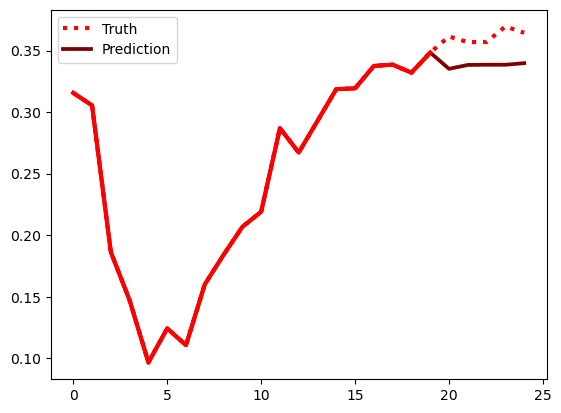

In [225]:
plot_test_TRUTH = val_df[600:600 + 25]['N2O'].to_numpy()
plot_test_baseline_pred = np.concatenate((plot_test_TRUTH[:-LEN_PRED_HORIZON], naive_rolling_mean(plot_test_TRUTH[:-LEN_PRED_HORIZON], window=5)))


plt.plot(plot_test_TRUTH[:], linestyle=':', color = 'r', linewidth = 3, label = 'Truth')
plt.plot(plot_test_baseline_pred[:], color = 'maroon', linewidth = 2.7, label = 'Prediction')
plt.plot(plot_test_TRUTH[:-LEN_PRED_HORIZON], color = 'r',linewidth = 3)
plt.legend()

In [154]:
def RMSE_rolling_mean(val_df):
    N2O_vals = val_df['N2O'].to_numpy()

    n_data_points = len(N2O_vals) - N_ROWS_IN_DAY + 1

    datapoints = np.lib.stride_tricks.sliding_window_view(N2O_vals, N_ROWS_IN_DAY)

    rows_with_nan = np.isnan(datapoints).any(axis=1)
    rows_without_nan = ~rows_with_nan
    datapoints = datapoints[rows_without_nan]

    errors = []

    for i, datapoint in enumerate(datapoints):
        errors.append(RMSE(naive_rolling_mean(datapoint[:-LEN_PRED_HORIZON], window = 3, horizon = LEN_PRED_HORIZON), datapoint[-LEN_PRED_HORIZON:]))
    
    return np.mean(errors)

In [155]:
print("rolling mean model RMSE on validation set: ", RMSE_rolling_mean(val_df))

rolling mean model RMSE on validation set:  4.577407512526548
